In [754]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFECV
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

In [755]:
def encode_condition_text(condition_text):
    conditions = { 
        "Clear and Sunny": 0, "Partly Cloudy": 1, "Light Precipitation": 2, "Cloudy and Overcast": 3,
        "Mist or Fog": 4, "Rain Showers": 5, "Light Rain with Thunder": 6, "Thunderstorms": 7, "Moderate to Heavy Rain": 8 
    }
    return conditions.get(condition_text, None)

def decode_condition_text(encoded_condition):
    conditions = {
        0: "Clear and Sunny", 1: "Partly Cloudy", 2: "Light Precipitation", 3: "Cloudy and Overcast",
        4: "Mist or Fog", 5: "Rain Showers", 6: "Light Rain with Thunder", 7: "Thunderstorms", 8: "Moderate to Heavy Rain" 
    }
    return conditions.get(encoded_condition, None)

In [756]:
def time_to_minutes(time_str):
    # Split the time into components
    time, period = time_str.split()
    hours, minutes = map(int, time.split(':'))

    # Convert hours to 24-hour format
    if period == 'PM' and hours != 12:
        hours += 12
    if period == 'AM' and hours == 12:
        hours = 0

    # Calculate minutes from midnight
    total_minutes = hours * 60 + minutes
    return total_minutes

In [757]:
def evaluate_model(random_state):
    class_weights = {
        0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 3, 6: 2, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1
    }
    model = RandomForestClassifier(random_state=random_state)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    cvs = cross_val_score(model, X, Y, cv=5).mean()
    return accuracy, cvs, model

In [758]:
def feature_selection_cv(X, Y, estimator, k_features):
    selector = SelectKBest(score_func=mutual_info_classif, k=k_features)
    X_selected = selector.fit_transform(X, Y)
    scores = cross_val_score(estimator, X_selected, Y, cv=5, scoring='accuracy')
    return scores.mean()

In [759]:
df = pd.read_csv('data/daily_data.csv')

In [760]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2893 entries, 0 to 2892
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   day_id                    2893 non-null   object 
 1   city_id                   2893 non-null   object 
 2   temperature_celsius       2893 non-null   float64
 3   condition_text            479 non-null    object 
 4   wind_kph                  2893 non-null   float64
 5   wind_degree               2893 non-null   int64  
 6   pressure_mb               2893 non-null   float64
 7   precip_mm                 2893 non-null   float64
 8   humidity                  2893 non-null   int64  
 9   cloud                     2893 non-null   int64  
 10  feels_like_celsius        2893 non-null   float64
 11  visibility_km             2893 non-null   float64
 12  uv_index                  2893 non-null   float64
 13  gust_kph                  2893 non-null   float64
 14  air_qual

In [761]:
df.isna().sum()

day_id                         0
city_id                        0
temperature_celsius            0
condition_text              2414
wind_kph                       0
wind_degree                    0
pressure_mb                    0
precip_mm                      0
humidity                       0
cloud                          0
feels_like_celsius             0
visibility_km                  0
uv_index                       0
gust_kph                       0
air_quality_us-epa-index       0
sunrise                        0
sunset                         0
dtype: int64

In [762]:
df.nunique()

day_id                      2893
city_id                      112
temperature_celsius          191
condition_text                 9
wind_kph                      84
wind_degree                  281
pressure_mb                   49
precip_mm                    122
humidity                      94
cloud                         87
feels_like_celsius           394
visibility_km                 30
uv_index                      10
gust_kph                     374
air_quality_us-epa-index       6
sunrise                      168
sunset                       198
dtype: int64

In [763]:
df["city_id"].value_counts()

city_id
C001    26
C002    26
C003    26
C004    26
C005    26
        ..
C109    26
C070    25
C094    25
C104    25
C105    10
Name: count, Length: 112, dtype: int64

In [764]:
df.head()

,day_id,city_id,temperature_celsius,condition_text,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feels_like_celsius,visibility_km,uv_index,gust_kph,air_quality_us-epa-index,sunrise,sunset
0,D0001,C001,27.0,NaN,6.1,210,1006.0,0.0,54,75,28.0,10.0,6.0,11.9,2,06:04 AM,07:19 PM
1,D0002,C001,22.0,NaN,6.1,170,1006.0,0.0,73,75,24.5,10.0,1.0,23.4,1,06:05 AM,07:18 PM
2,D0003,C001,20.0,Light Rain with Thunder,3.6,10,1011.0,4.5,100,75,20.0,10.0,1.0,12.6,1,06:05 AM,07:18 PM
3,D0004,C001,17.0,Clear and Sunny,6.1,150,1018.0,0.0,88,0,17.0,10.0,1.0,11.2,1,06:06 AM,07:16 PM
4,D0005,C001,18.0,NaN,3.6,92,1019.0,0.0,94,0,18.0,10.0,1.0,9.0,1,06:07 AM,07:15 PM


In [765]:
df = df.drop(columns=["city_id", "gust_kph"])

In [766]:
df["sunrise"] = df["sunrise"].apply(lambda x: time_to_minutes(x))
df["sunset"] = df["sunset"].apply(lambda x: time_to_minutes(x))

In [767]:
df["sun_duration"] = df["sunset"] - df["sunrise"]
df.drop(columns=["sunrise", "sunset"], inplace=True)

In [768]:
df["temperature"] = (df["temperature_celsius"] + df["feels_like_celsius"]) / 2
df.drop(columns=["temperature_celsius", "feels_like_celsius"], inplace=True)

In [769]:
df_known = df[df["condition_text"].notnull()]
df_unknown = df[df["condition_text"].isnull()]

In [770]:
df_known_copy = df_known.copy()
df_known.drop(columns=["day_id"], inplace=True)

C:\Users\hesha\AppData\Local\Temp\ipykernel_11976\3325062619.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_known.drop(columns=["day_id"], inplace=True)


In [771]:
df_known.head(100)

,condition_text,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,visibility_km,uv_index,air_quality_us-epa-index,sun_duration,temperature
2,Light Rain with Thunder,3.6,10,1011.0,4.5,100,75,10.0,1.0,1,793,20.0
3,Clear and Sunny,6.1,150,1018.0,0.0,88,0,10.0,1.0,1,790,17.0
6,Partly Cloudy,4.0,310,1015.0,0.0,100,50,10.0,1.0,2,783,21.0
18,Clear and Sunny,3.6,64,1017.0,0.0,88,0,10.0,1.0,3,751,19.0
27,Partly Cloudy,3.6,83,1010.0,0.0,73,25,10.0,1.0,1,783,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...
637,Clear and Sunny,6.1,190,1018.0,0.0,73,0,10.0,1.0,3,778,18.0
638,Clear and Sunny,6.8,150,1013.0,0.0,69,0,10.0,1.0,2,775,21.0
646,Clear and Sunny,16.9,190,1015.0,0.0,77,0,10.0,1.0,1,745,13.7
647,Clear and Sunny,9.0,150,1011.0,0.0,72,0,10.0,1.0,1,741,16.0


In [772]:
df_known["condition_text"] = df_known["condition_text"].apply(encode_condition_text)

C:\Users\hesha\AppData\Local\Temp\ipykernel_11976\3800365567.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_known["condition_text"] = df_known["condition_text"].apply(encode_condition_text)


In [773]:
# Min-Max Scaling
minmax_scaler = MinMaxScaler()
df_minmax_scaled = pd.DataFrame(minmax_scaler.fit_transform(df_known), columns=df_known.columns)

In [774]:
X = df_known.drop(columns=["condition_text"])
Y = df_known["condition_text"]

In [775]:
X.head()

,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,visibility_km,uv_index,air_quality_us-epa-index,sun_duration,temperature
2,3.6,10,1011.0,4.5,100,75,10.0,1.0,1,793,20.0
3,6.1,150,1018.0,0.0,88,0,10.0,1.0,1,790,17.0
6,4.0,310,1015.0,0.0,100,50,10.0,1.0,2,783,21.0
18,3.6,64,1017.0,0.0,88,0,10.0,1.0,3,751,19.0
27,3.6,83,1010.0,0.0,73,25,10.0,1.0,1,783,19.0


In [776]:
Y.head()

2     6
3     0
6     1
18    0
27    1
Name: condition_text, dtype: int64

<Axes: >

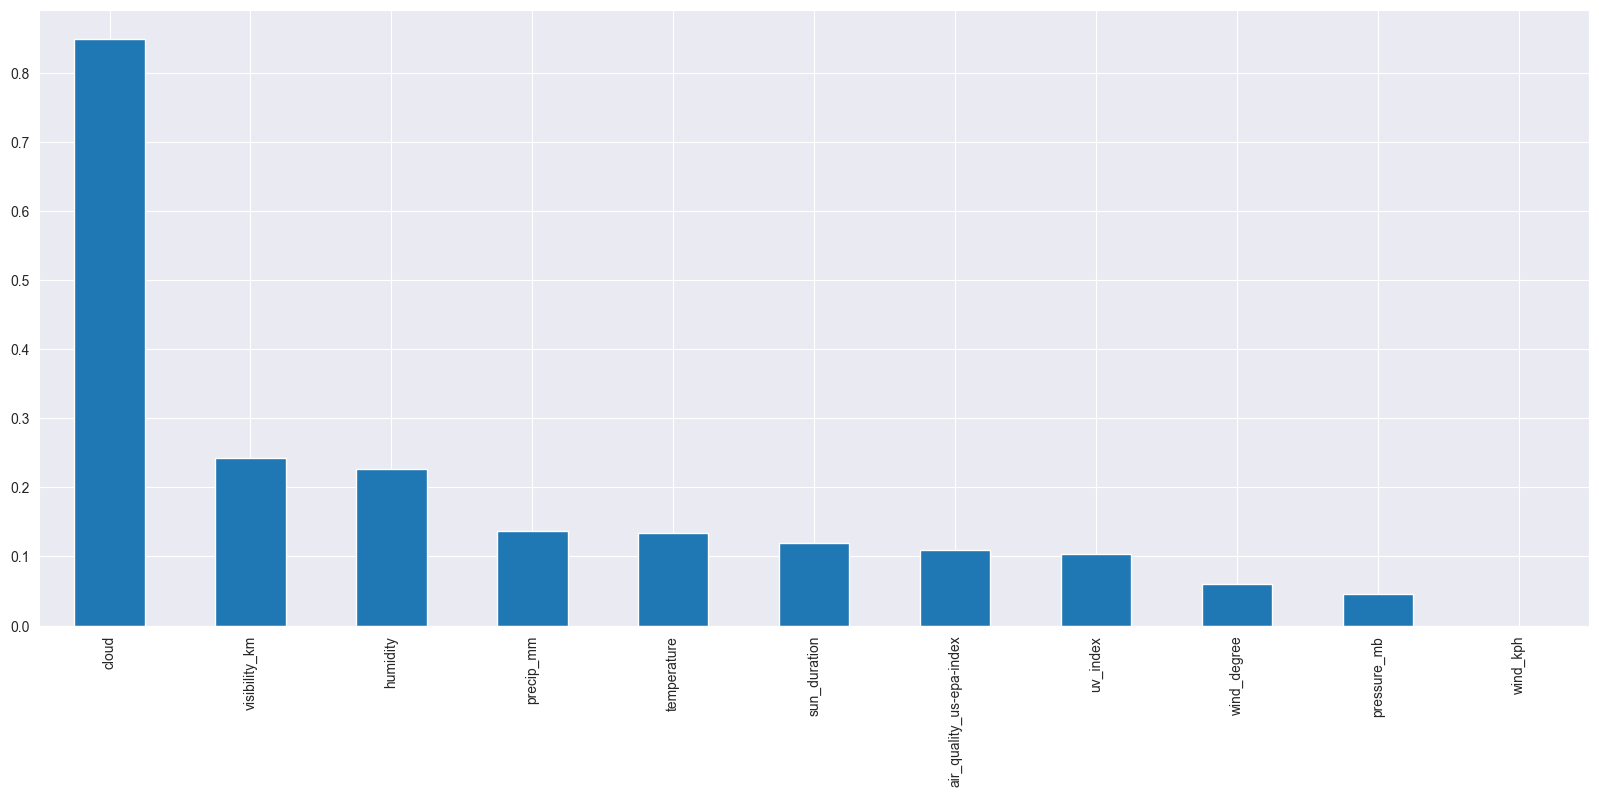

In [777]:
fs = SelectKBest(score_func=mutual_info_classif, k=10)
fs.fit(X, Y)
sc = pd.Series(fs.scores_, index=X.columns)
sc.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [778]:
# rfc = RandomForestClassifier(random_state=42)
# rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(5), scoring='accuracy')
# rfecv.fit(X, Y)
# 
# print("Optimal number of features: %d" % rfecv.n_features_)
# 
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
# plt.title("Feature Selection using RFE")
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross-validation score")
# plt.show()
# 
# selected_features = X.columns[rfecv.support_]
# print("Selected features:", selected_features)

In [779]:
# # Check Class Imbalance
# # Assuming your target variable is Y
# class_distribution = Y.value_counts()
# print("Class Distribution:")
# print(class_distribution)
# 
# # Calculate imbalance ratio
# imbalance_ratio = class_distribution.max() / class_distribution.min()
# print(f"Imbalance Ratio: {imbalance_ratio:.2f}")
# 
# # Visualize the distribution
# plt.figure(figsize=(10, 6))
# class_distribution.plot(kind='bar')
# plt.title("Class Distribution")
# plt.xlabel("Class")
# plt.ylabel("Count")
# plt.show()

## Train A Random Forest Classifier Model

In [780]:
class_weights = compute_class_weight('balanced', classes=np.unique(Y), y=Y)
class_weight_dict = dict(zip(np.unique(Y), class_weights))

In [781]:
x_train , x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [782]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

In [783]:
feature_weights = np.ones(x_train.shape[1])
feature_weights[6] = 2
sample_weights = x_train.dot(feature_weights)

In [784]:
print(class_weight_dict)

{np.int64(0): np.float64(0.43624772313296906), np.int64(1): np.float64(0.43624772313296906), np.int64(2): np.float64(0.7826797385620915), np.int64(3): np.float64(1.0041928721174005), np.int64(4): np.float64(1.0644444444444445), np.int64(5): np.float64(2.5343915343915344), np.int64(6): np.float64(3.326388888888889), np.int64(7): np.float64(3.5481481481481483), np.int64(8): np.float64(4.435185185185185)}


In [785]:
x_test.head()

,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,visibility_km,uv_index,air_quality_us-epa-index,sun_duration,temperature
624,9.0,320,1007.0,0.10,94,100,10.0,3.0,1,822,12.75
1790,29.9,140,1009.0,0.04,63,50,10.0,7.0,1,729,32.05
345,3.6,54,1018.0,2.50,94,100,10.0,1.0,1,783,15.00
237,11.2,193,1004.0,0.10,82,80,10.0,1.0,4,758,30.65
2715,11.2,330,1002.0,0.00,63,25,10.0,1.0,3,757,38.85


In [786]:
accs, cvss, models = [], [], []
for i in range(0,100):
    acc, cvs, model = evaluate_model(i)
    accs.append(acc)
    cvss.append(cvs)
    models.append(model)

print(f"Max Validation Accuracy: {max(accs)}, {accs.index(max(accs))}")
print(f"Max Cross Validation Accuracy: {max(cvss)}, {cvss.index(max(cvss))}")

Max Validation Accuracy: 0.75, 56
Max Cross Validation Accuracy: 0.7056140350877194, 65


In [787]:
y_pred = models[accs.index(max(accs))].predict(x_test)
print(classification_report(y_test, y_pred))
print(f"Max Validation Accuracy: {max(accs)}, {accs.index(max(accs))}")
print(f"Max Cross Validation Accuracy: {max(cvss)}, {cvss.index(max(cvss))}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.66      0.96      0.78        26
           2       0.64      0.75      0.69        12
           3       0.73      0.67      0.70        12
           4       0.88      0.88      0.88         8
           5       1.00      0.20      0.33         5
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         4

    accuracy                           0.75        96
   macro avg       0.54      0.49      0.49        96
weighted avg       0.70      0.75      0.70        96

Max Validation Accuracy: 0.75, 56
Max Cross Validation Accuracy: 0.7056140350877194, 65


E:\Personal\Python\Predicta\WeatherClassification\venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Personal\Python\Predicta\WeatherClassification\venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Personal\Python\Predicta\WeatherClassification\venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## Make Predictions And Prepare Submission

In [788]:
x_sub = df_unknown.drop(columns=["condition_text", "day_id"])
df_unknown['condition_text'] = models[accs.index(max(accs))].predict(x_sub)
df_unknown['condition_text'] = df_unknown['condition_text'].apply(decode_condition_text)
all_data = pd.concat([df_known_copy, df_unknown], axis=0)
all_data = all_data.sort_values(by='day_id')
submission_df = all_data[['day_id', 'condition_text']]
submission_df.to_csv('final_submission_2.csv', index=False)

C:\Users\hesha\AppData\Local\Temp\ipykernel_11976\923848912.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unknown['condition_text'] = models[accs.index(max(accs))].predict(x_sub)
C:\Users\hesha\AppData\Local\Temp\ipykernel_11976\923848912.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unknown['condition_text'] = df_unknown['condition_text'].apply(decode_condition_text)
